## Imports

In [18]:
import os
import sys
import pandas as pd
import seaborn as sns

from typing import List, Union
from pydantic import validate_arguments

# Importing functions from src/data
parent_dir = os.path.abspath(os.path.join('..'))
module_path = parent_dir + "/src/data"

if module_path not in sys.path:
    sys.path.append(module_path)

import database as db
import api
import pickle_helpers as pkle
import constants as cnt

In [4]:
parent_dir = os.path.abspath(os.path.join('..'))
parent_dir

'/home/salman1567/code/Data Science - Machine Learning Projects/Data Science Portfolio/Eve_Online_PI_Price_Forecaster'

## Table of Contents

1. [Data Collection](#data-collection)
2. [Data Validation](#data-validation)
3. [Preprocessing](#preprocessing)

### Data Collection

The average price is collected from an API and stored in a postgresql database. In order to retrieve the data in order to begin any analysis we make a query to the database which is handled by the market_data function below.

The data recieved is in the format of a list of 3-tuples containing a unique id, time and price at that time.

In [4]:
@validate_arguments
def market_data(item_name: str, region_id: str | int = "0", order_type: str = "buy", stat: str = "weightedAverage") -> List:
    """ Makes a query to the postgresql database market_data based on the parameters specified.

    Args:
        item_name (str): Provide the name of the raw material,
        
        region_id (str, int): Select region id of the market data. defaults to "0".
        
            - There are 7 Regions
                - Global - 0
                - Jita - 30000142
                - Perimeter - 30000144
                - Jita 4-4 CNAP - 60003760
                - Amarr VIII - 60008494
                - Dodixie - 60011866
                - Rens - 60004588
                - Hek - 60005686
                
        order_type (str, optional): Either 'buy' or 'sell' orders. Defaults to "buy".
        
        stat(str): Select the summary statistic to return

            - Valid args for stat:
                - weightedAverage
                - max
                - min
                - stddev
                - median
                - volume
                - orderCount
                - percentile

    Returns:
        List: Contains a list of tuples containing id, time, and data from market_data
    """
    # Validating and reformating arguments into proper format
    order_type = order_type.lower()
    
    if order_type != ("buy" or "sell"):
        raise ValueError(f"Found order_type to be of type {type(order_type)}")
    
    itemid = api.get_item_id(item_name)
    
    # Postgresql query unpacking JSON data field
    command = (
        f"""
        SELECT id, time, data -> '{itemid}' -> '{order_type}' -> '{stat}'
        FROM market_data
        WHERE region_id = {region_id}
        """
        )
    
    results = db.postgresql_command(command, results=True)
    
    return results
    

In [1]:
# Historical average buy order price for Silicon
#market_data("Silicon")

In [6]:
# Historical average buy order price for Silicon
df = pd.DataFrame(data=market_data("Silicon"), columns=["id", "time", "avg_price"])
df.avg_price = pd.to_numeric(df.avg_price)
df

Command executed successfully


,id,time,avg_price
0,9,2022-05-23 17:43:39.109944,330.190015
1,17,2022-05-23 17:51:28.265570,330.185014
2,25,2022-05-23 17:53:37.343203,330.185014
3,33,2022-05-23 17:56:09.378611,330.185014
4,41,2022-05-23 18:00:36.550194,330.185014
...,...,...,...
121,977,2022-05-30 12:00:39.347071,328.482254
122,985,2022-05-30 13:00:39.033141,328.143212
123,993,2022-05-30 14:00:38.958329,328.143212
124,1001,2022-05-30 15:00:39.350501,328.238807


[Text(0.5, 1.0, 'Avg Price for Silicon')]

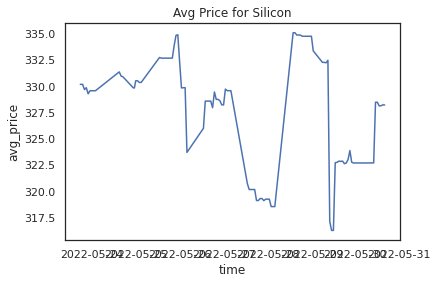

In [9]:
# Plot
sns.set_theme(style="white")
plt = sns.lineplot(x=df.time, y=df.avg_price)
plt.set(title="Avg Price for Silicon")



In [19]:
pickled_items_path = parent_dir + "/" + cnt.ITEMS_PATH
pkle.load_pickle_data(pickled_items_path)

[2348,
 9842,
 2307,
 3725,
 9830,
 2366,
 12836,
 2328,
 2305,
 9828,
 2321,
 2360,
 2397,
 2389,
 3697,
 2352,
 2344,
 2327,
 2868,
 2367,
 2329,
 17392,
 2309,
 2270,
 2308,
 2319,
 17136,
 2272,
 2310,
 2872,
 2287,
 2876,
 44,
 9840,
 3645,
 2288,
 9832,
 3683,
 2867,
 9846,
 2390,
 2400,
 2267,
 2869,
 2392,
 2399,
 3779,
 17898,
 2401,
 2346,
 9834,
 2870,
 2345,
 9838,
 3695,
 9836,
 2311,
 3775,
 9848,
 28974,
 2351,
 2268,
 2393,
 3693,
 2398,
 2354,
 2286,
 2875,
 15317,
 2395,
 2463,
 2871,
 2306,
 2396,
 3828,
 3691,
 2358,
 2361,
 2312,
 2349,
 3689,
 2073,
 2317]